In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload module is not an IPython extension.


UsageError: Line magic function `%autoreload` not found.


## Imports

In [2]:
import MDAnalysis as mda
import prolif as plf
import numpy as np
import pandas as pd
from rdkit import DataStructs
import glob
from tqdm import tqdm
import os
import seaborn as sns
import datamol as dm
import rdkit
import matplotlib.pyplot as plt
import torch
import warnings
from rdkit.Chem import AllChem
from copy import deepcopy
import rdkit.Chem as Chem

from src.data.datasets import *
from src.utils.prolif import (
    merge_interaction_dfs,
    generate_interaction_df,
    calculate_interaction_similarity,
)

## Main

In [3]:
crossdocked = get_dataset("crossdocked")
zinc = get_dataset("zinc")
diffsbdd = get_dataset("diffsbdd")
targetdiff = get_dataset("targetdiff")
cvae = get_dataset("cvae")
sbdd = get_dataset("sbdd")
p2m = get_dataset("p2m")

In [4]:
crossdocked_paths = glob.glob(
    "/Users/charlie/projects/poses_benchmark/data/crossdocked/**/*.sdf", recursive=True
)
sbdd_paths = glob.glob(
    "/Users/charlie/projects/poses_benchmark/data/benchmarks/sbdd/**/*.sdf",
    recursive=True,
)
p2m_paths = glob.glob(
    "/Users/charlie/projects/poses_benchmark/data/benchmarks/p2m/**/*.sdf",
    recursive=True,
)
cvae_paths = glob.glob(
    "/Users/charlie/projects/poses_benchmark/data/benchmarks/cvae/**/*.sdf",
    recursive=True,
)
diffsbdd_paths = glob.glob(
    "/Users/charlie/projects/poses_benchmark/data/diffsbdd_conditional_fullatom/**/*.sdf",
    recursive=True,
)

targetdiff_path = "/Users/charlie/projects/poses_benchmark/data/benchmarks/targetdiff/targetdiff_vina_docked.pt"
data = torch.load(targetdiff_path)

In [5]:
targetdiff = []

for target in data:
    for mol in target:
        targetdiff.append(mol["mol"])


len(targetdiff)

9036

In [ ]:
crossdocked = []
for path in crossdocked_paths:
    crossdocked.extend(dm.read_sdf(path))

sbdd = []
for path in sbdd_paths:
    sbdd.extend(dm.read_sdf(path))

p2m = []
for path in p2m_paths:
    p2m.extend(dm.read_sdf(path))

cvae = []
for path in cvae_paths:
    cvae.extend(dm.read_sdf(path))

diffsbdd = []
for path in diffsbdd_paths:
    diffsbdd.extend(dm.read_sdf(path))

In [8]:
print(len(crossdocked))
print(len(sbdd))
print(len(p2m))
print(len(cvae))
print(len(diffsbdd))
print(len(targetdiff))

100
8220
11609
8186
9352
9036


In [9]:
from SA_Score import sascorer

In [19]:
def sa_score(mol):
    sa = sascorer.calculateScore(mol)
    return round((10 - sa) / 9, 3)

In [71]:
def list_to_df(mols):
    print("Calculating QED")
    qeds = [Chem.QED.qed(mol) for mol in tqdm(mols)]
    print("Calculating SA")
    sas = [sa_score(mol) for mol in tqdm(mols)]

    df = pd.DataFrame({"mol": mols, "qed": qeds, "sa": sas})

    return df

In [72]:
crossdocked_df = list_to_df(crossdocked)
diffsbdd_df = list_to_df(diffsbdd)
targetdiff_df = list_to_df(targetdiff)
p2m_df = list_to_df(p2m)
sbdd_df = list_to_df(sbdd)
cvae_df = list_to_df(cvae)

Calculating QED


100%|██████████| 100/100 [00:00<00:00, 507.40it/s]


Calculating SA


100%|██████████| 100/100 [00:00<00:00, 226.30it/s]


Calculating QED


100%|██████████| 9352/9352 [00:10<00:00, 901.84it/s] 


Calculating SA


100%|██████████| 9352/9352 [00:37<00:00, 251.52it/s]


Calculating QED


100%|██████████| 9036/9036 [00:13<00:00, 688.53it/s]


Calculating SA


100%|██████████| 9036/9036 [00:38<00:00, 232.25it/s]


Calculating QED


100%|██████████| 11609/11609 [00:13<00:00, 874.39it/s] 


Calculating SA


100%|██████████| 11609/11609 [00:48<00:00, 240.32it/s]


Calculating QED


100%|██████████| 8220/8220 [00:08<00:00, 940.54it/s] 


Calculating SA


100%|██████████| 8220/8220 [00:28<00:00, 286.94it/s]


Calculating QED


100%|██████████| 8186/8186 [00:09<00:00, 819.68it/s] 


Calculating SA


100%|██████████| 8186/8186 [00:25<00:00, 322.90it/s]


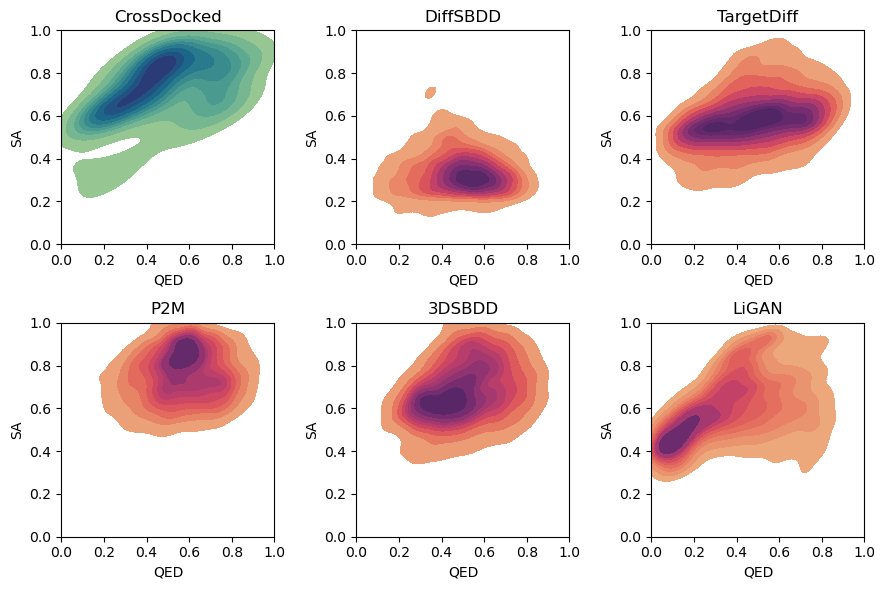

In [80]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

datasets = [crossdocked_df, diffsbdd_df, targetdiff_df, p2m_df, sbdd_df, cvae_df]
titles = ["CrossDocked", "DiffSBDD", "TargetDiff", "P2M", "3DSBDD", "LiGAN"]

for i in range(2):
    for j in range(3):
        dataset = datasets[i * 3 + j]
        # axs[i, j].scatter(dataset['qed'], dataset['sa'], s=1)
        sns.kdeplot(
            data=dataset,
            x="qed",
            y="sa",
            ax=axs[i, j],
            fill=True,
            levels=10,
            cmap="crest" if i + j == 0 else "flare",
        )
        axs[i, j].set_xlabel("QED")
        axs[i, j].set_ylabel("SA")
        axs[i, j].set_xlim(0, 1)
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_title(titles[i * 3 + j])

plt.tight_layout()
plt.savefig("figures/2d_metrics.pdf", dpi=300)